# Overfit and regularization exercises

## 0. Tips data EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

a)

In [5]:
df = sns.load_dataset("tips")
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


In [9]:
df.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


b)

Text(0.5, 0.98, 'Descriptive statistics for tip, total bill and size')

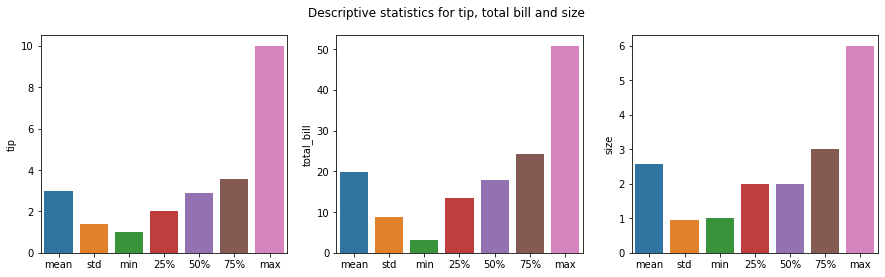

In [67]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
tip = df["tip"].describe()[1:]
sns.barplot(y=tip, x=tip.index, ax=ax[0])
total_bill = df["total_bill"].describe()[1:]
sns.barplot(y=total_bill, x=total_bill.index, ax=ax[1])
size = df["size"].describe()[1:]
sns.barplot(y=size, x=size.index, ax=ax[2])
fig.suptitle("Descriptive statistics for tip, total bill and size")

c)

Text(0.5, 1.0, 'Male and female distribution')

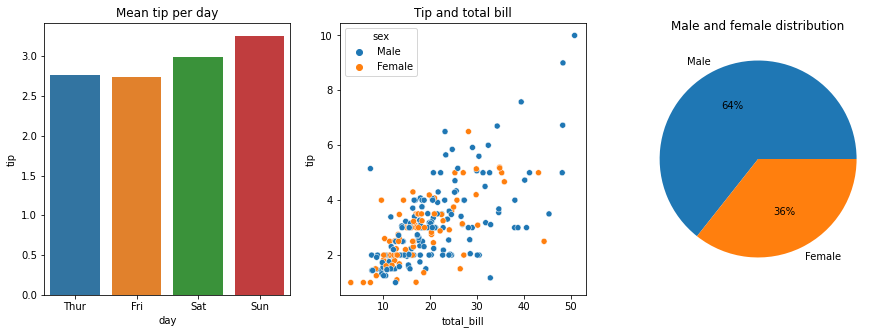

In [120]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

tip_day = df["tip"].groupby(df["day"]).mean()
sns.barplot(x=tip_day.index, y=tip_day, ax=ax[0])
ax[0].set_title("Mean tip per day")

sns.scatterplot(x=df["total_bill"], y=df["tip"], hue=df["sex"], ax=ax[1])
ax[1].set_title("Tip and total bill")

sex = df["sex"].value_counts()
ax[2].pie(sex, labels=sex.index, autopct='%.0f%%')
ax[2].set_title("Male and female distribution")

## 1. Train|test split

In [121]:
from sklearn.model_selection import train_test_split

In [148]:
X, y = df.drop(["tip", "sex", "smoker", "day", "time"], axis=1), df["tip"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((170, 2), (74, 2), (170,), (74,))

## 2. Feature standardization

In [162]:
from sklearn.preprocessing import StandardScaler

In [175]:
scaler = StandardScaler()
scaler.fit(X_train)

scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [177]:
print(f"Mean value of scaled X_train: [{np.mean(scaled_X_train[:,0])}, {np.mean(scaled_X_train[:,1])}]")
print(f"Mean value of scaled X_test: [{np.mean(scaled_X_test[:,0])}, {np.mean(scaled_X_test[:,1])}]")
print(f"Standard deviation value of scaled X_train: [{np.std(scaled_X_train[:,0])}, {np.std(scaled_X_train[:,1])}]")
print(f"Standard deviation value of scaled X_test: [{np.std(scaled_X_test[:,0])}, {np.std(scaled_X_test[:,1])}]")

Mean value of scaled X_train: [6.791952621236252e-17, -1.0449157878825003e-16]
Mean value of scaled X_test: [-0.19194537101655185, -0.04491163109964233]
Standard deviation value of scaled X_train: [1.0, 1.0]
Standard deviation value of scaled X_test: [0.9213997637553281, 1.0622880339691505]
